In [107]:
import math
import random
class Node:  # Node = Location = Point
    def __init__(self, id, x, y):
        self.x = float(x)
        self.y = float(y)
        self.id = int(id)

# 1 Open a file and create a data list using the info in the file
file_name = "training_dataset.sh"  # write path if the file is not in the same directory
dataset = []

In [108]:
with open(file_name, "r") as f:
    for line in f:  # check each line
        new_line = line.strip()  # remove spaces at the beginning and the end if they are available
        new_line = new_line.split(" ")  # split a string into a list
        id, x, y = new_line[0], new_line[1], new_line[2]  # check dataset file to see why id,x,y = 0,1,2
        dataset.append(Node(id=id, x=x, y=y))  # Create a Node object with id, x, y and add to the data list

N = 20  # Total number of unique points, including starting point

In [109]:
# This function will be run once at the beginning of the program to create a distance matrix
def create_distance_matrix(node_list):
    matrix = [[0 for _ in range(N)] for _ in range(N)]

    # classical matrix creation with two for loops
    for i in range(0, len(matrix)-1):
        for j in range(0, len(matrix[0])-1):
            # calculate euclidean distance btw each points and add to the matrix
            # a^2 = b^2 + c^2
            matrix[node_list[i].id][node_list[j].id] = math.sqrt(
                pow((node_list[i].x - node_list[j].x), 2) + pow((node_list[i].y - node_list[j].y), 2)
            )
    return matrix
matrix = create_distance_matrix(dataset)  # calculate all distances among all points and create a matrix
# This matrix is needed to decrease the runtime and complexity of general flow.

In [110]:
# Chromosome = Solution = Path
# Chromosome will contain Node list. This will be used in crossover, mutation operations etc,
# Chromosome representation --> chr_representation is only for displaying the route in a simple/clear way
# Chromosome cost will be used to compare the chromosomes
# We want to minimize the cost. So, lower cost is better!
class Chromosome:
    def __init__(self, node_list):
        self.chromosome = node_list

        chr_representation = []
        for i in range(0, len(node_list)):
            chr_representation.append(self.chromosome[i].id)
        self.chr_representation = chr_representation

        distance = 0
        for j in range(1, len(self.chr_representation) - 1):  # get distances from the matrix
            distance += matrix[self.chr_representation[j]-1][self.chr_representation[j + 1]-1]
        self.cost = distance

        self.fitness_value = 1 / self.cost

In [111]:
# create a random chromosome --> shuffle node list randomly
def create_random_list(n_list):
    start = n_list[0]  # start and end points should be same, so keep the first point before shuffling

    temp = n_list[1:]
    temp = random.sample(temp, len(temp))  # shuffle the node list

    temp.insert(0, start)  # add start point to the beginning of the chromosome
    temp.append(start)  # add start point to the end, because route should be ended where it started
    return temp

In [112]:
# initialization
def initialization(data, pop_size):
    initial_population = []
    for i in range(0, pop_size):  # create chromosomes as much as population size
        temp = create_random_list(data)
        new_ch = Chromosome(temp)
        initial_population.append(new_ch)
    return initial_population

In [113]:
# selection of parent chromosomes to create child chromosomes
def selection(population):  # tournament selection
    ticket_1, ticket_2, ticket_3, ticket_4 = random.sample(range(0, 99), 4)  # random 4 tickets

    # create candidate chromosomes based on ticket numbers
    candidate_1 = population[ticket_1]
    candidate_2 = population[ticket_2]
    candidate_3 = population[ticket_3]
    candidate_4 = population[ticket_4]

    # select the winner according to their costs
    if candidate_1.fitness_value > candidate_2.fitness_value:
        winner = candidate_1
    else:
        winner = candidate_2

    if candidate_3.fitness_value > winner.fitness_value:
        winner = candidate_3

    if candidate_4.fitness_value > winner.fitness_value:
        winner = candidate_4

    return winner  # winner = chromosome

In [114]:
# 1 One point crossover
def crossover(p_1, p_2):
    one_point = random.randint(2, 14)

    child_1 = p_1.chromosome[1:one_point]
    child_2 = p_2.chromosome[1:one_point]

    child_1_remain = [item for item in p_2.chromosome[1:-1] if item not in child_1]
    child_2_remain = [item for item in p_1.chromosome[1:-1] if item not in child_2]

    child_1 += child_1_remain
    child_2 += child_2_remain

    child_1.insert(0, p_1.chromosome[0])
    child_1.append(p_1.chromosome[0])

    child_2.insert(0, p_2.chromosome[0])
    child_2.append(p_2.chromosome[0])

    return child_1, child_2

In [115]:
# Mutation operation
def mutation(chromosome):  # swap two nodes of the chromosome
    mutation_index_1, mutation_index_2 = random.sample(range(1, 19), 2)
    chromosome[mutation_index_1], chromosome[mutation_index_2] = chromosome[mutation_index_2], chromosome[mutation_index_1]
    return chromosome

In [116]:
# Find the best chromosome of the generation based on the cost
def find_best(generation):
    best = generation[0]
    for n in range(1, len(generation)):
        if generation[n].cost < best.cost:
            best = generation[n]
    return best

In [117]:
def create_new_generation(previous_generation, mutation_rate):
    new_generation = [find_best(previous_generation)]  # This is for elitism. Keep the best of the previous generation.

    # Use two chromosomes and create two chromosomes. So, iteration size will be half of the population size!
    for a in range(0, int(len(previous_generation)/2)):
        parent_1 = selection(previous_generation)
        parent_2 = selection(previous_generation)

        child_1, child_2 = crossover(parent_1, parent_2)  # This will create node lists, we need Chromosome objects
        child_1 = Chromosome(child_1)
        child_2 = Chromosome(child_2)

        if random.random() < mutation_rate:
            mutated = mutation(child_1.chromosome)
            child_1 = Chromosome(mutated)

        new_generation.append(child_1)
        new_generation.append(child_2)

    return new_generation

In [118]:
import numpy as np
import matplotlib.pyplot as plt
# parameters
numbers_of_generations = 200  # in other words, iteration size
population_size = 100  # this shows how many solutions will be available in a generation
mut_rate = 0.2  # mutation rate for solution diversity. It should be btw 0 and 1. 0.2 means --> 20%
dataset = dataset  # locations info in a list form. Each element of the list is a Node object, which as id, x, y info


# main function for genetic algorithm
def genetic_algorithm(num_of_generations, pop_size, mutation_rate, data_list):
    new_gen = initialization(data_list, pop_size)  # first generation is created with initialization function

    costs_for_plot = []  # this list is only for Cost-Generations graph. it will constitute y-axis of the graph

    for iteration in range(0, num_of_generations):
        new_gen = create_new_generation(new_gen, mutation_rate)  # create a new generation in each iteration
        # print the cost of first chromosome of each new generation to observe the change over generations
        print(str(iteration) + ". generation --> " + "cost --> " + str(new_gen[0].cost))
        costs_for_plot.append(find_best(new_gen).cost)  # append the best chromosome's cost of each new generation
        # to the list to plot in the graph

    return new_gen, costs_for_plot

In [119]:
def draw_cost_generation(y_list):
    x_list = np.arange(1, len(y_list)+1)  # create a numpy list from 1 to the numbers of generations

    plt.plot(x_list, y_list)

    plt.title("Route Cost through Generations")
    plt.xlabel("Generations")
    plt.ylabel("Cost")

    plt.show()

In [120]:
def draw_path(solution):
    x_list = []
    y_list = []

    for m in range(0, len(solution.chromosome)):
        x_list.append(solution.chromosome[m].x)
        y_list.append(solution.chromosome[m].y)

    fig, ax = plt.subplots()
    plt.scatter(x_list, y_list)  # alpha=0.5

    ax.plot(x_list, y_list, '--', lw=2, color='black', ms=10)
    ax.set_xlim(0, 1650)
    ax.set_ylim(0, 1300)

    plt.show()

0. generation --> cost --> 11264.578897614707
1. generation --> cost --> 11073.138205713753
2. generation --> cost --> 10464.740662406572
3. generation --> cost --> 9601.960060150797
4. generation --> cost --> 9519.25073248352
5. generation --> cost --> 8999.45820449043
6. generation --> cost --> 8306.387561561087
7. generation --> cost --> 7865.1131957887
8. generation --> cost --> 7131.8204739697885
9. generation --> cost --> 6892.470978698729
10. generation --> cost --> 6496.114187176062
11. generation --> cost --> 6496.114187176062
12. generation --> cost --> 6496.114187176062
13. generation --> cost --> 6496.114187176062
14. generation --> cost --> 6496.114187176062
15. generation --> cost --> 6496.114187176062
16. generation --> cost --> 6496.114187176062
17. generation --> cost --> 6329.685757009612
18. generation --> cost --> 6329.685757009612
19. generation --> cost --> 6329.685757009612
20. generation --> cost --> 6329.685757009612
21. generation --> cost --> 6329.68575700961

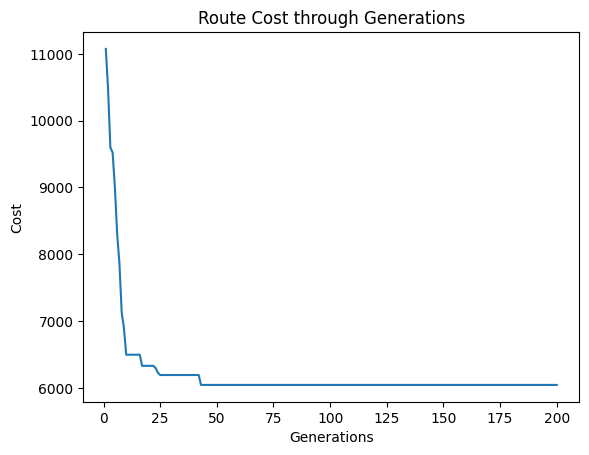

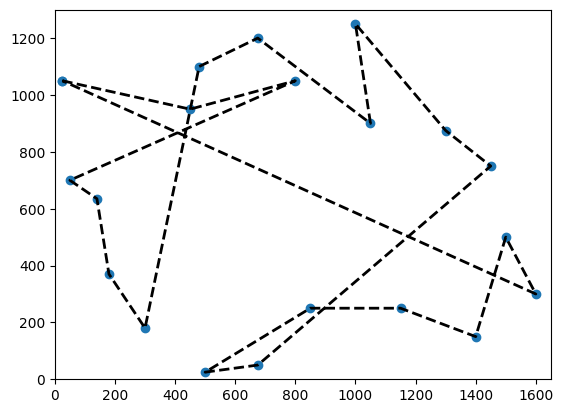

In [121]:
last_generation, y_axis = genetic_algorithm(
    num_of_generations=numbers_of_generations, pop_size=population_size, mutation_rate=mut_rate, data_list=dataset
)

best_solution = find_best(last_generation)

draw_cost_generation(y_axis)

draw_path(best_solution)